In [32]:
import os
import sys
import numpy as np
import cv2


import torch
from tqdm import tqdm

# Dataset
from dataset.frames_dataset_with_lmks import FramesDataset
from torch.utils.data import DataLoader

# Models

from modulesiris.generator import OcclusionAwareGenerator
import imageio

# Loss
device = 'cuda'

def load_model(ckpt):
    checkpoint = torch.load(ckpt, map_location=device)
     # Model here
    dense_motion_params = {"block_expansion":64, "max_features": 1024, "num_blocks":5, "scale_factor":0.25, "using_first_order_motion":False,"using_thin_plate_spline_motion":True}
    G = OcclusionAwareGenerator(num_channels=3, num_kp=8, block_expansion=64, max_features=512, num_down_blocks=2,
                 num_bottleneck_blocks=6, estimate_occlusion_map=True, dense_motion_params=dense_motion_params, estimate_jacobian=True)
    
    G.load_state_dict(checkpoint["G_state_dict"], strict=True)
    G = G.to(device)
    return G

def draw_landmarks(img, lmks, color=(255,0,0)):
    img = np.ascontiguousarray(img)
    for a in lmks:
        cv2.circle(img,(int(round(a[0])), int(round(a[1]))), 1, color, -1, lineType=cv2.LINE_AA)

    return img


def vis(x, x_prime_hat, kp_src, kp_driving):
        """
        x: Bx3x1xHxW
        x_prime: Bx3x1xHxW
        x_prime_hat: Bx3x1xHxW
        kp_src: Bx1x10x2
        kp_driving: Bx1x10x2
        """
        _,_,h,w = x.shape
        x = x.detach().cpu().numpy()
        x_prime_hat = x_prime_hat.detach().cpu().numpy()


        kp_src = kp_src.detach().cpu().numpy()
        kp_driving = kp_driving.detach().cpu().numpy()

        for i, (x1, x3, ks, kd) in enumerate(zip(x, x_prime_hat, kp_src, kp_driving)):
            x1 = (np.transpose(x1, (1,2,0))*255.0).astype(np.uint8)
            x3 = (np.transpose(x3, (1,2,0))*255.0).astype(np.uint8)
            ks = (ks+1) * np.array([w,h]) / 2.0
            kd = (kd+1) * np.array([w,h]) / 2.0
            x1 = draw_landmarks(x1, ks)
            x3 = draw_landmarks(x3, ks)
            x3 = draw_landmarks(x3, kd, color=(0,255,255))

            img = np.hstack((x1, x3))
            return img



def synthize_kp_driving(kp_src, delta_x=None, delta_y=None, delta_x_right=None, delta_y_right=None):
    kp_driving = {}
    kp_driving["value"] =  kp_src["value"].clone()

    kp_driving["value"][:,-2,0] = kp_driving["value"][:,-2,0] + delta_x
    kp_driving["value"][:,-2,1] = kp_driving["value"][:,-2,1] + delta_y

    kp_driving["value"][:,-1,0] = kp_driving["value"][:,-1,0] + delta_x_right
    kp_driving["value"][:,-1,1] = kp_driving["value"][:,-1,1] + delta_y_right
    kp_driving["value_witheyelid"] =  kp_driving["value"].clone()
    return kp_driving


from skimage import io, img_as_float32

# Load model
# ckpt = "checkpoints/motion_iris/11.pth.tar"
# ckpt = "checkpoints/motion_iris_fix_motion_equation/15.pth.tar"
# ckpt = "checkpoints/motion_iris_fix_motion_test/8.pth.tar"
# ckpt = "checkpoints/motion_iris_thin_plate_spline_motion/20.pth.tar"
ckpt = "checkpoints/motion_iris_thin_plate_spline_motion_more_control_points/15.pth.tar"
G = load_model(ckpt = ckpt)
G.eval()



YOOOOOOOOOOO dense_motion_params :{'block_expansion': 64, 'max_features': 1024, 'num_blocks': 5, 'scale_factor': 0.25, 'using_first_order_motion': False, 'using_thin_plate_spline_motion': True}


OcclusionAwareGenerator(
  (dense_motion_network): DenseMotionNetwork(
    (hourglass): Hourglass(
      (encoder): Encoder(
        (down_blocks): ModuleList(
          (0): DownBlock2d(
            (conv): Conv2d(36, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
          )
          (1): DownBlock2d(
            (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): SynchronizedBatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
          )
          (2): DownBlock2d(
            (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): SynchronizedBatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, trac

In [14]:
# from scipy.spatial.transform import Rotation as R
# from math import sin, cos
# R_gaze = R.from_euler('xy', [20,20], degrees=True).as_matrix() # rotation from gaze to camera
# print(R_gaze)
# pitch = 20*3.14/180.0
# yaw=20*3.14/180.0
# Rx = np.array([[1, 0, 0], [0, cos(pitch), -sin(pitch)], [0, sin(pitch), cos(pitch)]]);
# Ry = np.array([[cos(yaw), 0, sin(yaw)], [0, 1, 0], [-sin(yaw), 0,  cos(yaw)]]);
# R1 = Ry@Rx
# print(Ry@Rx)

# pitch1 =  np.arcsin(-R1[1][2])
# yaw1 = np.arcsin(R1[0][2]/np.cos(pitch1))
# print(pitch1*180.0/3.14, yaw1*180.0/3.14)


[[ 9.39692621e-01  1.16977778e-01  3.21393805e-01]
 [-1.38777878e-17  9.39692621e-01 -3.42020143e-01]
 [-3.42020143e-01  3.21393805e-01  8.83022222e-01]]
[[ 0.93975313  0.11686405  0.32125822]
 [ 0.          0.93975313 -0.34185385]
 [-0.34185385  0.32125822  0.88313595]]
20.0 20.0


In [17]:
# from scipy.spatial.transform import Rotation as R

# camera_matrix = np.array(
#                         [[1384.819218268528, 0, 657.7229991401907],
#                         [0, 1371.5943763928485, 375.8607466170705],
#                         [0, 0, 1]], dtype = "double"
#                         )
# homo_point = np.ones((3,))
# ce_2d = [641.659,452.849]
# gaze = np.array([-12.519, 13.2642])*3.14/180.0

# homo_point[:2] = ce_2d
# # print("CEnter lmks 2d: ", ce_2d)
# axis_z = np.linalg.inv(camera_matrix) @ homo_point  # z axis point to the face center
# axis_y_cam = np.array((0, 1, 0))  # keep y the same
# axis_x = np.cross(axis_y_cam, axis_z) # re-caculate x 
# axis_y = np.cross(axis_z, axis_x)
# R_norm_to_origin = np.stack((
#     axis_x/np.linalg.norm(axis_x),
#     axis_y/np.linalg.norm(axis_y),
#     axis_z/np.linalg.norm(axis_z),
# ), axis=1) # rotation from normalize camera to origin camera
# R_norm = np.linalg.inv(R_norm_to_origin)

# R_norm_gaze = R.from_euler('xy', gaze, degrees=False).as_matrix() # rotation from gaze to camera
# R_gaze_norm_inv = R_norm.T@R_norm_gaze
# pitch_inv =  np.arcsin(-R_gaze_norm_inv[1][2])
# yaw_inv = np.arcsin(R_gaze_norm_inv[0][2]/np.cos(pitch_inv))
# norm_gaze_inv = np.array([pitch_inv, yaw_inv])
# print(norm_gaze_inv*180.0/3.14)

[-15.64627196  12.78538559]


4.525031472088639 1.6129310879051761


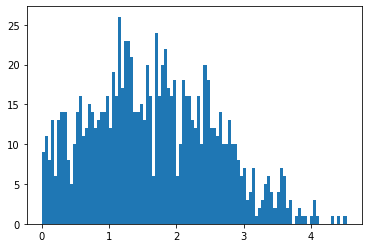

In [31]:
# import matplotlib.pyplot as plt
# def estimate_dis_err(f, d, d_mm ):
#     return d_mm*f/d

# f = 1300
# d = 500
# d_mm = 11

# errs = []
# pixel = estimate_dis_err(f, d, 11)
# for i in range(1000):
#     r = np.random.normal(30, 20, 1)[0]
#     pixel1 = estimate_dis_err(f, d+r, 11)
#     errs.append(abs(pixel1-pixel))

# print(np.max(errs), np.median(errs))
# plt.hist(errs, bins=100)
# plt.show()

In [81]:
# from scipy.spatial.transform import Rotation as R

# # R_gaze = R.from_euler('xy', [0.1,0.3], degrees=False).as_matrix() # rotation from gaze to camera
# # print(R_gaze)
# class GazeAnglePixelMappingTest():
#     def __init__(self, facelmksmodel='data/face68model.txt'):
#         self.facelmksmodel = facelmksmodel
#         self.points_3d = self.__get_full_model_points(self.facelmksmodel)
        
#     def __get_full_model_points(self, filename='data/face68model.txt'):
#         """Get all 68 3D model points from file"""
#         raw_value = []
#         with open(filename) as file:
#             for line in file:
#                 raw_value.append(line)
#         model_points = np.array(raw_value, dtype=np.float32) / 10
#         model_points = np.reshape(model_points, (3, -1)).T
#         p2122 = model_points[33]
#         model_points = model_points - p2122

#         return model_points
    
#     def find_iris_position(self, eyeballcenter, eyecenter, gaze_pitch, gaze_yaw):
#         # My = R.from_euler('y', [gaze_yaw], degrees=False).as_matrix()
#         # Mx = R.from_euler('x', [gaze_pitch], degrees=False).as_matrix()
#         # iris_rotate_y = My@(eyecenter-eyeballcenter) + eyeballcenter
#         # iris = Mx@(iris_rotate_y[0]-eyeballcenter) + eyeballcenter
#         # return iris[0]

#         M = R.from_euler('xy', [gaze_pitch, gaze_yaw], degrees=False).as_matrix()
#         # M = R.from_euler('yx', [gaze_yaw, gaze_pitch], degrees=False).as_matrix()
#         # print(eyecenter-eyeballcenter, eyeballcenter)
#         iris = M@(eyecenter-eyeballcenter) + eyeballcenter
#         return iris
        

#     def synthesize_iris(self, eyeballcenter, eyecenter, gaze_pitch, gaze_yaw, delta_pitch=-0.2, delta_yaw=0.2):
#         new_pitch = gaze_pitch + delta_pitch
#         new_yaw = gaze_yaw + delta_yaw
#         print(f'new_pitch :{new_pitch}. New_yaw :{new_yaw}')
#         synthesize_iris = self.find_iris_position(eyeballcenter=eyeballcenter, eyecenter=eyecenter, gaze_pitch=new_pitch, gaze_yaw=new_yaw)
#         return synthesize_iris
                 
#     def deltagaze_2_delta_xy(self, lmks2D, fx, fy, cx, cy, gaze, delta_gaze):
#         """
#         /brief Return delta xy of iris given delta_gaze
#         @fx, fy, cx, cy: Intrinsic parameter
#         @gaze eyegaze
#         @delta_gaze Change ini eyegaze
#         """
#         # Frontalize face and get the eyegaze in the eyeball coordinate
#         camera_matrix = np.array([[fx, 0.0, cx], [0.0, fy, cy], [0.0, 0.0, 1.0]])
#         dist_coeffs = np.zeros((4, 1))
#         ret, rvec, tvec = cv2.solvePnP(self.points_3d, lmks2D, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_EPNP)
#         hR = cv2.Rodrigues(rvec)[0] # rotation matrix
#         ht = tvec[:,0]*10 # cm to mm
#         R_gaze = R.from_euler('xy', gaze, degrees=False).as_matrix() # rotation from gaze to camera
#         R_gaze_in_eyeball = hR.T @ R_gaze
#         pitch_in_eyeball =  np.arcsin(-R_gaze_in_eyeball[1][2])
#         yaw_in_eyeball = np.arcsin(R_gaze_in_eyeball[0][2]/np.cos(pitch_in_eyeball))

#         # Caculate eyeball center of leye, reye
#         points = self.points_3d.copy()
#         c_leye = points[36]/2.0 + points[39]/2.0
#         l_eyeball = c_leye.copy()
#         l_eyeball[2] = l_eyeball[2] + 11/10 # cm
        
#         c_reye = points[42]/2.0 + points[45]/2.0
#         r_eyeball = c_reye.copy()
#         r_eyeball[2] = r_eyeball[2] + 11/10 # cm
        
#         # print(c_leye, c_reye)
        
#         # Find position of old iris and new iris for 2 eyes
#         left_iris = self.find_iris_position(eyeballcenter=l_eyeball, eyecenter=c_leye, gaze_pitch=pitch_in_eyeball, gaze_yaw=yaw_in_eyeball)
#         left_syn_iris = self.synthesize_iris(eyeballcenter=l_eyeball, eyecenter=c_leye, gaze_pitch=pitch_in_eyeball, gaze_yaw=yaw_in_eyeball, delta_pitch=delta_gaze[0], delta_yaw=delta_gaze[1])
#         right_iris = self.find_iris_position(eyeballcenter=r_eyeball, eyecenter=c_reye, gaze_pitch=pitch_in_eyeball, gaze_yaw=yaw_in_eyeball)
#         right_syn_iris = self.synthesize_iris(eyeballcenter=r_eyeball, eyecenter=c_reye, gaze_pitch=pitch_in_eyeball, gaze_yaw=yaw_in_eyeball, delta_pitch=delta_gaze[0], delta_yaw=delta_gaze[1])
#         iris_points = np.array([left_iris, left_syn_iris, right_iris, right_syn_iris])
#         # print(iris_points)
#         # Project to 2d
#         camera_matrix = np.array([[fx, 0.0, cx], [0.0, fy, cy], [0.0, 0.0, 1.0]])
#         dist_coeffs = np.zeros((4, 1))
#         points2d, _ = cv2.projectPoints(iris_points, rvec, tvec, camera_matrix, dist_coeffs)
#         points2d = np.reshape(points2d, (-1, 2)) 
#         print(f'Point2d project :{points2d}')

#         ################# Test another way to project points
#         tmp_3d = (hR@iris_points.T).T + ht/10.0
#         tmp_2d = camera_matrix@tmp_3d.T
#         tmp_2d = tmp_2d.T
#         tmp_2d = tmp_2d/np.expand_dims(tmp_2d[:,2], -1)
#         print(f'tmp2d project :{tmp_2d}')

#         ## i1 piexel = K@[g1@O + Rt0 + t]
#         g1 = R.from_euler('xy', gaze, degrees=False).as_matrix()
#         O = c_leye - l_eyeball
#         print(f'O :{O}')
#         t = ht/10.0
#         print(f'translation: {t}')
#         t0 = l_eyeball
#         iris_2d_left_old = (g1@O.T).T + (hR@t0.T).T + t
#         iris_2d_left_old = (camera_matrix@iris_2d_left_old.T).T
#         # iris_2d_left_old = iris_2d_left_old/iris_2d_left_old[2]
#         print(f"Iris 2d old: {iris_2d_left_old}")

#         new_gaze_tmp = gaze+np.array(delta_gaze)
#         print(f"New gaze tmp :{new_gaze_tmp}")
        
#         g2 = R.from_euler('xy', new_gaze_tmp, degrees=False).as_matrix()
#         O = c_leye - l_eyeball
#         t = ht/10.0
#         t0 = l_eyeball
#         iris_2d_left_new = (g2@O.T).T + (hR@t0.T).T + t
#         iris_2d_left_new = (camera_matrix@iris_2d_left_new.T).T
#         # iris_2d_left_new = iris_2d_left_new/iris_2d_left_new[2]
#         print(f"Iris 2d new: {iris_2d_left_new}")
#         ddddd1 = iris_2d_left_new-iris_2d_left_old 
#         ddddd1 = ddddd1/ddddd1[2]
#         print(f'Dentaaaaaaaaaaaaaaaaaaaaa yeah1 :{ddddd1[0]}, {ddddd1[1]}, {ddddd1[2]}')

#         g2_o = g2@O.T
#         g1_o = g1@O.T
#         delta_2d =  g2_o - g1_o
#         delta_2d[2] = g2_o[2]

#         # delta_2d = (g2@O.T - g1@O.T)
#         delta_2d = camera_matrix@delta_2d 
#         delta_2d = delta_2d/delta_2d[2]
#         print(f"Delta 2d: {delta_2d[0], delta_2d[1], delta_2d[2]}")

#         ##################3 End test
        
        
#         delta_xy_left = points2d[1] - points2d[0]
#         delta_xy_right = points2d[3] - points2d[2]
        
#         return delta_xy_left, delta_xy_right

# def load_lmks2d(txt):
#     with open(txt, 'r') as f:
#         lmks = f.readline().split(",")
#         lmks = [float(l) for l in lmks]
#         lmks = np.reshape(lmks, (-1, 2))
        
#         return np.array(lmks)

# def lmks2box(lmks, img, expand=1.0):
#     xy = np.min(lmks, axis=0).astype(np.int32) 
#     zz = np.max(lmks, axis=0).astype(np.int32)

#     xy[1] = max(xy[1], 0) 
#     wh = zz - xy + 1

#     center = (xy + wh/2).astype(np.int32)
#     # EXPAND=1.1
#     EXPAND=expand
#     boxsize = int(np.max(wh)*EXPAND)
#     xy = center - boxsize//2
#     x1, y1 = xy
#     x2, y2 = xy + boxsize
#     height, width, _ = img.shape
#     x1 = max(0, x1)
#     y1 = max(0, y1)
#     x2 = min(width, x2)
#     y2 = min(height, y2)
#     return [x1, y1, x2, y2]

# mapper = GazeAnglePixelMappingTest(facelmksmodel="./devudata/face68model.txt")
# fx=640
# fy=640
# cx=320
# cy=240
# gaze = np.array([0.087149,-0.718345])
# lmks68_2D = load_lmks2d("devudata/lmks68.txt")
# lmks106_2D = load_lmks2d("devudata/lmks106.txt")
# fullframe = cv2.imread("devudata/img.png")
# delta_pitch = 60
# delta_yaw = 60
# left_del, right_del = mapper.deltagaze_2_delta_xy(lmks68_2D, fx, fy, cx, cy, gaze, [delta_pitch*3.14/180.0, delta_yaw*3.14/180.0])
# print(f'Left delta: {left_del}')

new_pitch :1.081383205341898. New_yaw :0.5348885869005978
new_pitch :1.081383205341898. New_yaw :0.5348885869005978
Point2d project :[[371.11152789 214.58661264]
 [363.71684639 222.10914024]
 [421.71408712 213.3411207 ]
 [414.16616228 220.76031034]]
tmp2d project :[[371.11152789 214.58661264   1.        ]
 [363.71684639 222.10914024   1.        ]
 [421.71408712 213.3411207    1.        ]
 [414.16616228 220.76031034   1.        ]]
O :[ 0.         0.        -1.0999999]
translation: [ 9.68604429  1.35357211 76.47153198]
Iris 2d old: [29162.22113681 16862.37634888    78.58074715]
New gaze tmp :[1.13381567 0.32832167]
Iris 2d new: [28727.58049818 17531.20044271    78.96512947]
Dentaaaaaaaaaaaaaaaaaaaaa yeah1 :-1130.750848754447, 1739.9970103123737, 1.0
Delta 2d: (1585.4717451849663, -1068.4285534224935, 1.0)
Left delta: [-7.3946815  7.5225276]


In [31]:
305191.91840724/766.82421718

397.99462715142835

In [89]:
# def estimate_deltaxy(fx, fy, cx, cy, gaze1, delta_pitch, delta_yaw, R_eyeball=11, e=0):
#     camera_matrix = np.array([[fx, 0.0, cx], [0.0, fy, cy], [0.0, 0.0, 1.0]])
#     gaze1 = gaze1*180.0/3.14
#     gaze2 = gaze1 + np.array([delta_pitch, delta_yaw])
#     print(f'gaze1 :{gaze1}. gaze2:{gaze2}')
#     g1 = R.from_euler('xy', gaze1, degrees=True).as_matrix() # rotation from gaze to camera
#     g2 = R.from_euler('xy', gaze2, degrees=True).as_matrix() # rotation from gaze to camera
#     O = np.array([0.0,0.0, -R_eyeball/10.0]) # cm
#     # delta_g = g2-g1
#     # g_colum3 = delta_g[:,2] # g13, g23, g33 
#     # g_colum3 = g_colum3*(O+e)
#     # delta_2d = camera_matrix@g_colum3 
#     delta_2d = (g2@O.T - g1@O.T)
#     delta_2d = camera_matrix@delta_2d 

#     # delta_2d = delta_2d/delta_2d[2]
#     trans = np.array([9.68604429,  1.35357211, 76.47153198])
#     D = np.linalg.norm(trans)
#     delta_2d = delta_2d/59
#     print(f"Delta 2d: {delta_2d[0], delta_2d[1], delta_2d[2]}")

# fx=640
# fy=640
# cx=320
# cy=240
# gaze = np.array([0.087149,-0.718345])
# delta_pitch = 60
# delta_yaw = 60
# estimate_deltaxy(fx, fy, cx, cy, gaze, delta_pitch, delta_yaw, R_eyeball=11, e=0)

gaze1 :[  4.99580255 -41.17901274]. gaze2:[64.99580255 18.82098726]
Delta 2d: (-7.367175540607195, 11.339606131697453, 0.006520066537314548)


In [73]:
(-1129/154, 1739.185645852006/154)

(-7.3311688311688314, 11.293413284753285)

In [49]:
from scipy.spatial.transform import Rotation as R

class GazeAnglePixelMapping():
    def __init__(self, facelmksmodel='data/face68model.txt'):
        self.facelmksmodel = facelmksmodel
        self.points_3d = self.__get_full_model_points(self.facelmksmodel)
        
    def __get_full_model_points(self, filename='data/face68model.txt'):
        """Get all 68 3D model points from file"""
        raw_value = []
        with open(filename) as file:
            for line in file:
                raw_value.append(line)
        model_points = np.array(raw_value, dtype=np.float32) / 10
        model_points = np.reshape(model_points, (3, -1)).T
        p2122 = model_points[33]
        model_points = model_points - p2122

        return model_points
    New Synthesized Iris
        /brief Return delta xy of iris given delta_gaze
        @fx, fy, cx, cy: Intrinsic parameter
        @gaze eyegaze
        @delta_gaze Change ini eyegaze
        """
        # Frontalize face and get the eyegaze in the eyeball coordinate
        camera_matrix = np.array([[fx, 0.0, cx], [0.0, fy, cy], [0.0, 0.0, 1.0]])
        dist_coeffs = np.zeros((4, 1))
        ret, rvec, tvec = cv2.solvePnP(self.points_3d, lmks2D, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_EPNP)
        hR = cv2.Rodrigues(rvec)[0] # rotation matrix
        ht = tvec[:,0]*10 # cm to mm
        R_gaze = R.from_euler('xy', gaze, degrees=False).as_matrix() # rotation from gaze to camera
        R_gaze_in_eyeball = hR.T @ R_gaze
        pitch_in_eyeball =  np.arcsin(-R_gaze_in_eyeball[1][2])
        yaw_in_eyeball = np.arcsin(R_gaze_in_eyeball[0][2]/np.cos(pitch_in_eyeball))

        # Caculate eyeball center of leye, reye
        points = self.points_3d.copy()
        c_leye = points[36]/2.0 + points[39]/2.0
        l_eyeball = c_leye.copy()
        l_eyeball[2] = l_eyeball[2] + 11/10 # cm
        
        c_reye = points[42]/2.0 + points[45]/2.0
        r_eyeball = c_reye.copy()
        r_eyeball[2] = r_eyeball[2] + 11/10 # cm
        
        # print(c_leye, c_reye)
        
        # Find position of old iris and new iris for 2 eyes
        left_iris = self.find_iris_position(eyeballcenter=l_eyeball, eyecenter=c_leye, gaze_pitch=pitch_in_eyeball, gaze_yaw=yaw_in_eyeball)
        left_syn_iris = self.synthesize_iris(eyeballcenter=l_eyeball, eyecenter=c_leye, gaze_pitch=pitch_in_eyeball, gaze_yaw=yaw_in_eyeball, delta_pitch=delta_gaze[0], delta_yaw=delta_gaze[1])
        right_iris = self.find_iris_position(eyeballcenter=r_eyeball, eyecenter=c_reye, gaze_pitch=pitch_in_eyeball, gaze_yaw=yaw_in_eyeball)
        right_syn_iris = self.synthesize_iris(eyeballcenter=r_eyeball, eyecenter=c_reye, gaze_pitch=pitch_in_eyeball, gaze_yaw=yaw_in_eyeball, delta_pitch=delta_gaze[0], delta_yaw=delta_gaze[1])
        iris_points = np.array([left_iris, left_syn_iris, right_iris, right_syn_iris])
        print("iris point: ", iris_points)
        print("eye center point: ", c_leye, c_reye)

        # print(hR)
        # print(ht)

        # Project to 2d
        camera_matrix = np.array([[fx, 0.0, cx], [0.0, fy, cy], [0.0, 0.0, 1.0]])
        dist_coeffs = np.zeros((4, 1))
        points2d, _ = cv2.projectPoints(iris_points, rvec, tvec, camera_matrix, dist_coeffs)
        points2d = np.reshape(points2d, (-1, 2)) 
        
        delta_xy_left = points2d[1] - points2d[0]
        delta_xy_right = points2d[3] - points2d[2]
        
        return delta_xy_left, delta_xy_right



In [50]:
# Fake image
def load_lmks2d(txt):
    with open(txt, 'r') as f:
        lmks = f.readline().split(",")
        lmks = [float(l) for l in lmks]
        lmks = np.reshape(lmks, (-1, 2))
        
        return np.array(lmks)

def lmks2box(lmks, img, expand=1.0):
    xy = np.min(lmks, axis=0).astype(np.int32) 
    zz = np.max(lmks, axis=0).astype(np.int32)

    xy[1] = max(xy[1], 0) 
    wh = zz - xy + 1

    center = (xy + wh/2).astype(np.int32)
    # EXPAND=1.1
    EXPAND=expand
    boxsize = int(np.max(wh)*EXPAND)
    xy = center - boxsize//2
    x1, y1 = xy
    x2, y2 = xy + boxsize
    height, width, _ = img.shape
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(width, x2)
    y2 = min(height, y2)
    return [x1, y1, x2, y2]

def synthesize_image(src, lmks106_2d, box,delta_x, delta_y, delta_x_right, delta_y_right):
    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    src = cv2.resize(src, (256, 256)) #BxCxDxH,W
    src = src/255.0
    x  = np.transpose(src, (2,0,1)) # 3x256x256
    
    lmks106_2d = lmks106_2d - np.array([box[0], box[1]])

    lmks_anchors = lmks106_2d[[0, 8,16,24,32, 54,104, 105]]
    lmks_anchors = lmks_anchors*2/(box[2]-box[0]) - 1.0 # NOrm into -1--> 1
    kp_src = {"value": torch.FloatTensor(lmks_anchors), "value_witheyelid": torch.FloatTensor(lmks_anchors)}


    x = torch.FloatTensor(x)
    kp_src["value"] = torch.FloatTensor(kp_src["value"])
    x = x.to(device) 
    kp_src["value"] = kp_src["value"].to(device)
    kp_src["value_witheyelid"] = kp_src["value_witheyelid"].to(device)

    kp_src["value"].unsqueeze_(0) 
    kp_src["value_witheyelid"].unsqueeze_(0) 

    x.unsqueeze_(0) 
    kp_driving = synthize_kp_driving(kp_src, delta_x, delta_y, delta_x_right, delta_y_right)
    kp_driving["value"] = kp_driving["value"].to(device)
    kp_driving["value_witheyelid"] = kp_driving["value_witheyelid"].to(device)
    # kp_driving["value"].unsqueeze_(0) 
    # kp_driving["value_witheyelid"].unsqueeze_(0) 


    prediction = G(source_image=x, kp_driving=kp_driving, kp_source=kp_src)
    img_out = vis(x, prediction["prediction"], kp_src["value"], kp_driving["value"])

    return img_out, prediction

def load_lmks2d(txt):
    with open(txt, 'r') as f:
        lmks = f.readline().split(",")
        lmks = [float(l) for l in lmks]
        lmks = np.reshape(lmks, (-1, 2))
        
        return np.array(lmks)

def lmks2box(lmks, img, expand=1.0):
    xy = np.min(lmks, axis=0).astype(np.int32) 
    zz = np.max(lmks, axis=0).astype(np.int32)

    xy[1] = max(xy[1], 0) 
    wh = zz - xy + 1

    center = (xy + wh/2).astype(np.int32)
    # EXPAND=1.1
    EXPAND=expand
    boxsize = int(np.max(wh)*EXPAND)
    xy = center - boxsize//2
    x1, y1 = xy
    x2, y2 = xy + boxsize
    height, width, _ = img.shape
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(width, x2)
    y2 = min(height, y2)
    return [x1, y1, x2, y2]


In [6]:
fullframe = cv2.imread("devudata/img.png")
fullframe.shape

(480, 640, 3)

In [51]:
from ipywidgets import interact, interactive, fixed, interact_manual, Image
import cv2


def draw_gaze(image_in, eye_pos, pitchyaw, length=15.0, thickness=2, color=(0, 0, 255)):
    """Draw gaze angle on given image with a given eye positions."""
    image_out = image_in
    if len(image_out.shape) == 2 or image_out.shape[2] == 1:
        image_out = cv2.cvtColor(image_out, cv2.COLOR_GRAY2BGR)
    dx = -length * np.sin(pitchyaw[1])* np.cos(pitchyaw[0])
    dy = length * np.sin(pitchyaw[0])
    cv2.arrowedLine(image_out, tuple(np.round(eye_pos).astype(np.int32)),
                   tuple(np.round([eye_pos[0] + dx, eye_pos[1] + dy]).astype(int)), color,
                   thickness, cv2.LINE_AA, tipLength=0.2)

    return image_out


@interact(delta_pitch=(-60, 60, 5), delta_yaw=(-60, 60, 5))
def synthesize(delta_pitch, delta_yaw):
    # Information
    lmks68_2D = load_lmks2d("devudata/lmks68.txt")
    lmks106_2D = load_lmks2d("devudata/lmks106.txt")
    fullframe = cv2.imread("devudata/img.png")
    print(lmks68_2D.shape)
    x1,y1,x2,y2 = lmks2box(lmks68_2D, fullframe,expand=1.2)

    face = fullframe[y1:y2, x1:x2]
    scale_x = 256.0/(x2-x1)
    scale_y = 256.0/(y2-y1)
    mapper = GazeAnglePixelMapping(facelmksmodel="./devudata/face68model.txt")
    fx=640
    fy=640
    cx=320
    cy=240
    gaze = np.array([0.087149,-0.718345])
    left_del, right_del = mapper.deltagaze_2_delta_xy(lmks68_2D, fx, fy, cx, cy, gaze, [delta_pitch*3.14/180.0, delta_yaw*3.14/180.0])
    
    # Scale delta x,y in full image to cropface 256 x256
    left_del[0] = left_del[0]*scale_x
    right_del[0] = right_del[0]*scale_x 
    left_del[1] = left_del[1]*scale_y
    right_del[1] = right_del[1]*scale_y 
   

    # print("before: ", left_del, right_del)
    left_del = left_del*2/(256)  # Norm into -1, 1
    right_del = right_del*2/(256) # Norm into -1, 1
    # print("after: ", left_del, right_del)

    img, prediction = synthesize_image(src=face, lmks106_2d=lmks106_2D, box=[x1,y1,x2,y2],delta_x=left_del[0], delta_y=left_del[1], delta_x_right=right_del[0], delta_y_right=right_del[1])

    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = draw_gaze(img, (150, 40), [gaze[0], gaze[1]], length=75)
    img = draw_gaze(img, (150+256, 40), [gaze[0]+delta_pitch*3.14/180.0, gaze[1]+delta_yaw*3.14/180.0], length=75, color=(255,0,0))

    img_bytes = cv2.imencode('.png', img)[1].tobytes()
    widget = Image(value=img_bytes, format='png')
    return (widget)
    # return x

interactive(children=(IntSlider(value=0, description='delta_pitch', max=60, min=-60, step=5), IntSlider(value=…

In [53]:
gaze = np.array([0.087149,-0.718345])

gaze*180.0/3.14

array([  4.99580255, -41.17901274])

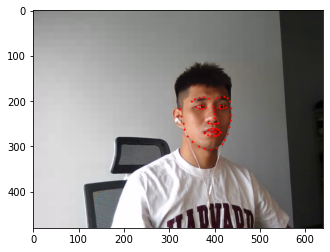

In [43]:
import matplotlib.pyplot as plt
def draw_landmarks(img, lmks, color=(255,0,0)):
    img = np.ascontiguousarray(img)
    for a in lmks:
        cv2.circle(img,(int(round(a[0])), int(round(a[1]))), 2, color, -1, lineType=cv2.LINE_AA)

    return img
lmks68_2D = load_lmks2d("devudata/lmks68.txt")
fullframe = cv2.imread("devudata/img.png")
fullframe = cv2.cvtColor(fullframe, cv2.COLOR_BGR2RGB)
fullframe = draw_landmarks(fullframe,lmks68_2D)
plt.imshow(fullframe)